## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Final conclusion](#Final-conclusion)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.

For this project, we will be working to understand the results of an A/B test run by an e-commerce website.  Our goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [132]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

**a.** Read in the dataset and take a look at the top few rows here:

In [133]:
# Loading the data file
df= pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [134]:
# Take a glimpse of the data to check if there is any messy and ensure different data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [135]:
# Change the 'timestamp' column form string type to the appropriate format
df['timestamp']= df['timestamp'].astype('datetime64')

In [136]:
# Check if changes done successfully
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   user_id       294478 non-null  int64         
 1   timestamp     294478 non-null  datetime64[ns]
 2   group         294478 non-null  object        
 3   landing_page  294478 non-null  object        
 4   converted     294478 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 11.2+ MB


In [137]:
# Calculating the duration of the given test for post analysis
test_duration= df.timestamp.max() - df.timestamp.min()
test_duration

Timedelta('21 days 23:59:49.081927')

**b.** Use the cell below to find the number of rows in the dataset.

In [138]:
df.shape[0]

294478

**c.** The number of unique users in the dataset.

In [139]:
df.user_id.nunique()

290584

**d.** The proportion of users converted.

In [140]:
df.converted.mean()

0.11965919355605512

**e.** The number of times the `new_page` and `treatment` don't match.

In [141]:
(df.query('group == "treatment" & landing_page == "old_page" | group == "control" & landing_page == "new_page"')).shape[0]

3893

**f.** Do any of the rows have missing values?

In [142]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   user_id       294478 non-null  int64         
 1   timestamp     294478 non-null  datetime64[ns]
 2   group         294478 non-null  object        
 3   landing_page  294478 non-null  object        
 4   converted     294478 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 11.2+ MB


> - **No, all columns appear without any missing data.**

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

**a.** Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [143]:
df2= df.query('group == "treatment" & landing_page == "new_page" | group == "control" & landing_page == "old_page"')
df2.shape[0]

290585

In [144]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

**a.** How many unique **user_id**s are in **df2**?

In [145]:
df2.user_id.nunique()

290584

**b.** There is one **user_id** repeated in **df2**.  What is it?

In [146]:
repeated_user= df2.user_id.value_counts().loc[lambda x: x>1].to_frame()
repeated_user

,user_id
773192,2


**c.** What is the row information for the repeat **user_id**? 

In [147]:
repeatd_rows= df2[df2['user_id'] == repeated_user.index[0]]
repeatd_rows

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


**d.** Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [148]:
pd.options.mode.chained_assignment = None

df2.drop(index= repeatd_rows.index[1], inplace=True)

In [149]:
# Double check that repeated row deleted successfully 
repeatd_rows= df2[df2['user_id'] == repeated_user.index[0]]
repeatd_rows

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0


`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

**a.** What is the probability of an individual converting regardless of the page they receive?

In [150]:
combine_conv= df2.converted.mean()
combine_conv

0.11959708724499628

**b.** Given that an individual was in the `control` group, what is the probability they converted?

In [151]:
control_conv= df2.query('group == "control"').converted.mean()
control_conv

0.1203863045004612

**c.** Given that an individual was in the `treatment` group, what is the probability they converted?

In [152]:
treatment_conv= df2.query('group == "treatment"').converted.mean()
treatment_conv

0.11880806551510564

**d.** What is the probability that an individual received the new page?

In [153]:
(df2['landing_page'] == 'new_page').mean()

0.5000619442226688

**e.** Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

>**There is no significant practical evidence to support the new page assumption.**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

> $$H_0:p_{new} - p_{old} \leq 0$$
> $$H_1:  p_{new} - p_{old} > 0$$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

**a.** What is the **conversion rate** for $p_{new}$ under the null? 

In [154]:
p_new= combine_conv
p_new

0.11959708724499628

**b.** What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [155]:
p_old= combine_conv
p_old

0.11959708724499628

**c.** What is $n_{new}$, the number of individuals in the treatment group?

In [156]:
n_new= df2.query('group == "treatment"').shape[0]
n_new

145310

**d.** What is $n_{old}$, the number of individuals in the control group?

In [159]:
n_old= df2.query('group == "control"').shape[0]
n_old

145274

**e.** Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [160]:
np.random.seed(42)
new_page_converted= np.random.choice([0,1], size= n_new, p=[1-p_new, p_new])

**f.** Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [161]:
np.random.seed(42)
old_page_converted= np.random.binomial(n= 1, p= p_old, size= n_old)

**g.** Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [163]:
diff= (new_page_converted==1).mean() - (old_page_converted==1).mean()
diff

3.258880437348455e-05

**h.** Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [164]:
np.random.seed(42)
p_diffs= [(np.random.binomial(1,p_new,n_new)==1).mean() - (np.random.binomial(1,p_old,n_old)==1).mean() for _ in range(10000)]

**i.** Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

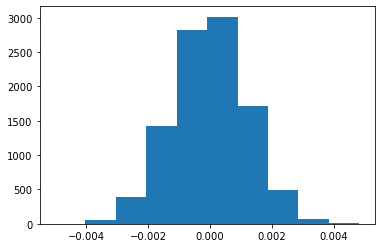

In [165]:
plt.hist(p_diffs);

**j.** What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [166]:
# Calculating the statistical difference
obs_diff= df2.query('group == "treatment"').converted.mean() - df2.query('group == "control"').converted.mean()

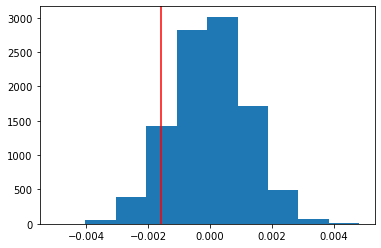

In [167]:
# Plotting the the sampling distribution and a line representing the observed difference
plt.hist(p_diffs)
plt.axvline(obs_diff, color='r');

In [168]:
# Convert "p_diffs" from list type to array type then determine the "P_value"
p_diffs= np.array(p_diffs)
(p_diffs > obs_diff).mean()

0.9009

**k.** Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

> - **We calculated the `P-Value`, which represents the probability of getting the observed statistics or higher given that the `NULL` hypothesis is true.**
>
> - **So, as long our calculated `P-Value` is greater than $\alpha$ of `5%`, we failed to reject the "Null Hypothesis" and will stick to the fact of the conversion rate of the new page is *$\leq$* the old page.** 

**l.** We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [169]:
import statsmodels.api as sm

convert_old = df2.query('group == "control"').converted.sum()
convert_new = df2.query('group == "treatment"').converted.sum()
n_old = df2.query('group == "control"').shape[0]
n_new = df2.query('group == "treatment"').shape[0]

In [170]:
print('A total {} converted of the {} visits of the old page'.format(convert_old, n_old))

A total 17489 converted of the 145274 visits of the old page


In [171]:
print('A total {} converted of the {} visits of the new page'.format(convert_new, n_new))

A total 17264 converted of the 145310 visits of the new page


**m.** Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [172]:
z_score, p_val= sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')
z_score, p_val

(1.3109241984234394, 0.9050583127590245)

**n.** What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

> - **The new calculated $P_{value}$ consistent with the previous one and confirm that we failed to reject the `Null` hypothesis as mentioned in parts `j` and `k`.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

**a.** Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

> - **Logistic-Regression is the appropriate approach for this type of response variable `converted`.**

**b.** The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [177]:
# Adding new column for the intercept
df2['intercept']=1

# Adding a column for the dummy value for the two groups
df2[['control', 'ab_page']]= pd.get_dummies(df2['group'])
df2.drop('control', axis=1, inplace=True)

# Check if all done successfully
df2.sample(5)

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
243118,791573,2017-01-13 11:01:28.951409,treatment,new_page,0,1,1
193036,816056,2017-01-07 22:10:53.901412,treatment,new_page,0,1,1
120910,634791,2017-01-12 16:53:51.638216,treatment,new_page,0,1,1
27951,738315,2017-01-14 18:18:00.715983,treatment,new_page,0,1,1
85776,723382,2017-01-22 21:09:13.908150,treatment,new_page,1,1,1


**c.** Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [178]:
lm1 = sm.Logit(df2['converted'],df2[['intercept','ab_page']])
result1 = lm1.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


**d.** Provide the summary of your model below, and use it as necessary to answer the following questions.

In [179]:
result1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Tue, 15 Dec 2020   Pseudo R-squ.:               8.077e-06
Time:                        03:19:20   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

**e.** What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

> **Our regression model hypothesis is:**
> $$H_0: P_{new} - P_{old} = 0$$
> $$H_1: P_{new} - P_{old} \neq 0$$

> - **$P_{value}$ of ab_page = 0.190**
> - **This one differs from the one we calculated in PartII because this model is a `2-sided` test as it appears in the hypotheses, while the first one was a `one-side` test. However, both have the same Z-Score of about `1.31`.**

**f.** Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

> - **Adding more relevant variables will improve our model's statistical significance and will help us to give a more robust prediction/recommendation. But, at the same same time, we should consider the complexity of our model.**

**g.** Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [201]:
# Loading the other data file of the users' countries
countries= pd.read_csv('countries.csv')
countries.sample(5)

,user_id,country
86786,720979,US
108972,837177,CA
131328,874465,UK
183459,751760,UK
67599,702220,US


In [202]:
# Merge our two data frames then adding two dummy columns for the mentioned countries
if 'country' not in df2.columns:
    df2= df2.merge(countries, on='user_id', how='inner')
    df2[['US','CA']]= pd.get_dummies(df2['country'])[['US','CA']]
    
# Take a glimpse of our modified data frame
df2.sample(5)

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,US,CA
22223,761970,2017-01-16 15:42:00.805751,treatment,new_page,0,1,1,US,1,0
277224,633040,2017-01-05 02:52:39.179306,treatment,new_page,0,1,1,US,1,0
52082,937131,2017-01-02 13:43:24.473268,treatment,new_page,0,1,1,US,1,0
108155,877401,2017-01-22 20:00:11.004820,treatment,new_page,0,1,1,US,1,0
188199,696959,2017-01-17 09:03:33.953702,treatment,new_page,0,1,1,UK,0,0


In [203]:
lm2 = sm.Logit(df2['converted'],df2[['intercept','ab_page','US','CA']])
result2 = lm2.fit()
result2.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Tue, 15 Dec 2020   Pseudo R-squ.:               2.323e-05
Time:                        03:20:02   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9794      0.013   -155.415      0.000      -2.004      -1.954
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
US            -0.0099      0.013     -0.743      0.457      -0.036       0.016
CA            -0.0506      0.028     -1.784      0.074      -0.106       0.005
==============================================================================
"""

> - **As it appears that $P_{value}$ for both `US`, and `UK` are `0.457, and .074` respectively which greater than our $\alpha$ of `5%`. So, we failed again to reject the `Null` hypothesis, that is users' location/country has no effect on the conversion rate.**

**h.** Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [204]:
# Adding another two columns representing the interaction for each country
df2['US_interaction']= df2['ab_page'] * df2['US']
df2['CA_interaction']= df2['ab_page'] * df2['CA']

# Display sample of the modified data frame
df2.sample(5)

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,US,CA,US_interaction,CA_interaction
207881,858382,2017-01-23 01:28:10.637361,control,old_page,0,1,0,UK,0,0,0,0
66069,886180,2017-01-09 18:36:40.411125,control,old_page,0,1,0,US,1,0,0,0
31536,731906,2017-01-05 07:00:30.145966,treatment,new_page,0,1,1,UK,0,0,0,0
90251,826885,2017-01-22 23:47:33.824249,control,old_page,0,1,0,US,1,0,0,0
66794,656463,2017-01-16 17:19:56.323128,treatment,new_page,0,1,1,US,1,0,1,0


In [205]:
lm3= sm.Logit(df2['converted'], df2[['intercept','ab_page','US','CA','US_interaction','CA_interaction']])
result3= lm3.fit()
result3.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Tue, 15 Dec 2020   Pseudo R-squ.:               3.482e-05
Time:                        03:20:13   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept         -1.9922      0.016   -123.457      0.000      -2.024      -1.961
ab_page            0.0108      0.023      0.475      0.635      -0.034       0.056
US                 0.0057      0.019      0.306      0.760      -0.031       0.043
CA                -0.0118      0.040     -0.296      0.767      -0.090       0.066
US_interaction    -0.0314      0.027     -1.181      0.238      -0.084       0.021
CA_interaction    -0.0783      0.057     -1.378      0.168      -0.190       0.033
==================================================================================
"""

> - **The $P_{value}$ of the `ab_page` variable improved dramatically from about `0.19` to about `0.64`, the same happened for the other two dummy variables `US, and CA` to be `0.76, and 0.77` respectively from `0.457, and 0.074`.**
>
> - **In the same time our new dummy varaibles `US_interaction, and CA_interaction` $P_{value}$ also greater than our predefined $\alpha$.**
>
> - **All these points solidify our initial prediction that the new page hasn't any impact on the conversion rate.**

<a id='conclusions'></a>
## Final conclusion

> - It is obvious that either with our initial variable `group` or with all the added ones like `countries, and countries-interactions`, we failed to reject the `Null` hypothesis that the `new_page` conversion rate is $\leq$ `old_page`.
>
> - So, as per the given data set, there is no neither statistical nor practical significance to recommend this upgrade and its associated cost to the company.
>
> - But, from another point of view, we could get different results if we run this experiment for a longer time than this one which ran for almost `22 days`.

In [206]:
# Exporting a ".html" version of the notebook
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0